Some consideration before starting:
-Edit cifar10.py file, setting the directory where CIFAR10 dataset is located.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
cifar10 = CIFAR10(batch_size=100, validation_proportion=0.1, augment_data=False)

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.get_variable("biases", [kernel_shape[3]],
                             initializer=tf.constant_initializer(0.0))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv2d(input_tensor, weights, 
                       strides = [1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)
    

In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input')
tf.summary.image('input', model_input, 10)

keep_prob = tf.placeholder(tf.float32, name='dropout_prob')

target = tf.placeholder(tf.float32, name='target')

# First convolution layer
layer_name = 'conv1'
with tf.variable_scope(layer_name):
    conv1_out = conv_layer(model_input, [5, 5, 3, 64], layer_name)
# First pooling layer
with tf.name_scope('pool1'):
    pool1_out = tf.nn.max_pool(conv1_out, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME',
                          name='pool1')

# Second convolution layer
layer_name = 'conv2'
with tf.variable_scope(layer_name):
    conv2_out = conv_layer(pool1_out, [5, 5, 64, 64], layer_name)
# Second pooling layer
with tf.name_scope('pool2'):
    pool2_out = tf.nn.max_pool(conv2_out, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME',
                          name='pool2')

pool2_out_flat = tf.reshape(pool2_out, [-1, 8*8*64], name='pool2_flat')

# First fully connected layer
layer_name = 'fc1'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(pool2_out_flat, [8*8*64, 512], layer_name)

fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

# Second fully connected layer
layer_name = 'fc2'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [512, 10], layer_name)

with tf.name_scope('loss_function'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=fc2_out, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [6]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(1e-4)
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(fc2_out, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run((accuracy),
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run((merged),
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run((accuracy),
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [7]:
# Train model
tf.set_random_seed(1)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/train',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validation')
sess.run(tf.global_variables_initializer())
cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)
epochs = 10
mean_gradients = np.zeros([len(tf.trainable_variables()),epochs])
std_gradients = np.zeros([len(tf.trainable_variables()),epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run((train_step),
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run((merged),
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 1.0 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer,epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer,epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
fc1/weights:0
fc1/biases:0
fc2/weights:0
fc2/biases:0
Epoch 0, training loss 2.269412, accuracy 0.160000
Validation accuracy 0.110600
Time elapsed 0.22395326693852743 minutes


KeyboardInterrupt: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  


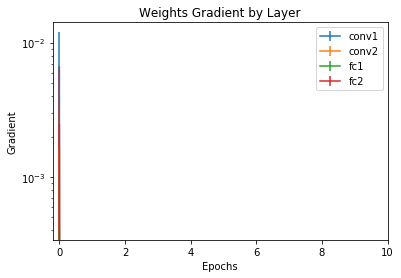

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


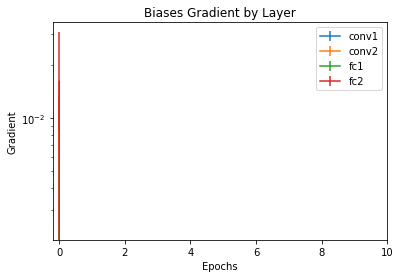

In [8]:
# Plotting gradients
x = np.arange(epochs)
i = 0
plt.hold(True)
while i < len(tf.trainable_variables()):
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.hold(False)
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.hold(True)
while i < len(tf.trainable_variables()):
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.hold(False)
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"])
plt.xlim(-0.2, epochs)
plt.show()